In [1]:
from ase.io import read, write
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS, FIRE, MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units, Atoms
from ase.calculators.lj import LennardJones
from castle import utils, LinearPotential, LPEnsemble, LPLocalEnsemble, print_score, AceRepresentation, ASEMLCalculator, ExpandedPotential

rcuts = {'Cu': 3.9, 'Mo': 5.2, 'Si': 4.7, 'Ge':5.1, 'Ni':4.0, 'Li':5.1, 'W':5.0}

%load_ext autoreload
%autoreload 2

In [2]:
traj = read(root + "w-14.xyz", index = ':')
ind = np.arange(len(traj))
np.random.shuffle(ind)
tr_ind = ind[:int(0.8*len(traj))] 
val_ind = ind[int(0.8*len(traj)):]
tr_traj = [traj[t] for t in tr_ind]
val_traj = [traj[i] for i in val_ind]
write(root + "train_trajectory.xyz", tr_traj)
write(root + "validation_trajectory.xyz", val_traj)

NameError: name 'read' is not defined

In [3]:
species = 'W'
N = 4
maxdeg = 12
rcut = rcuts[species]
force_name = 'force'
energy_name = 'energy'
e_noise = 1e-8
f_noise = 1e-6
root = f"/home/claudio/postdoc/data/{species}/"

tr_features, val_features = utils.extract_features(root, "train.xyz", "test.xyz", 
                                                   N=N, maxdeg=maxdeg, rcut=rcut, force_name=force_name,
                                                   energy_name=energy_name, species=species)

e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    root, "train.xyz", "test.xyz", 
    f"tr_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",  f"val_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",
    force_name = force_name, energy_name =energy_name)

Computing Features[############################################################] 7754/7754
Computing Features[############################################################] 1939/1939


In [4]:
tr_traj = read(root + "train.xyz", index = ':')
val_traj = read(root + "test.xyz", index = ':')
representation = tr_features.representation

### Linear Model

CPU times: user 43 ms, sys: 120 ms, total: 163 ms
Wall time: 21.7 ms
MAE=0.012 RMSE=0.016 SUP=0.050 R2=0.995
MAE=0.148 RMSE=0.217 SUP=2.551 R2=0.979


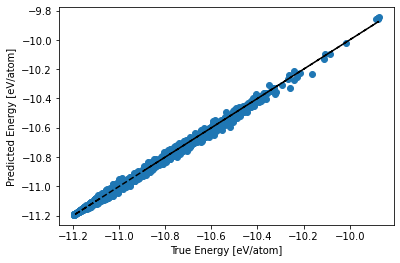

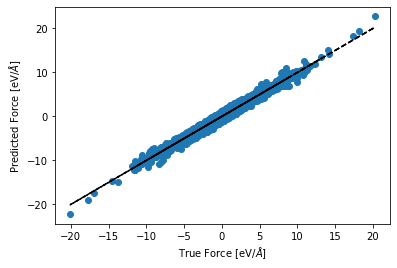

In [5]:
representation = AceRepresentation(N, maxdeg, rcut, species, energy_name=energy_name, force_name=force_name, add_sqrt=True)
model_lin = LinearPotential(representation)
model_lin.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise, noise_optimization=False)

# evaluate its performances
%time predictions = model_lin.predict_from_features(val_features, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

CPU times: user 28.1 ms, sys: 164 ms, total: 192 ms
Wall time: 25.9 ms
MAE=0.012 RMSE=0.016 SUP=0.051 R2=0.995
MAE=0.148 RMSE=0.216 SUP=1.998 R2=0.980


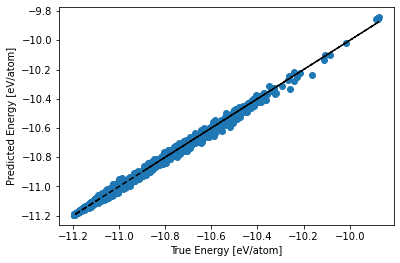

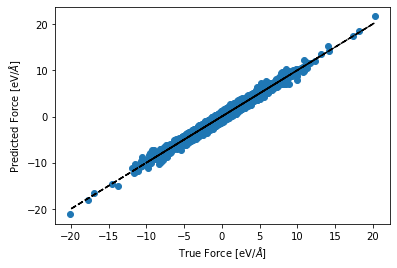

In [6]:
model_lin.update_from_features(val_features, e_val, f_val)

%time predictions = model_lin.predict_from_features(val_features, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

### Ensemble Model

Clustering data
Using 12 clusters
CPU times: user 2.45 s, sys: 621 ms, total: 3.07 s
Wall time: 2.33 s
MAE=0.012 RMSE=0.047 SUP=0.094 R2=0.957
MAE=0.133 RMSE=0.207 SUP=10.292 R2=0.981


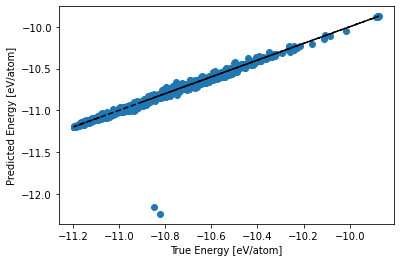

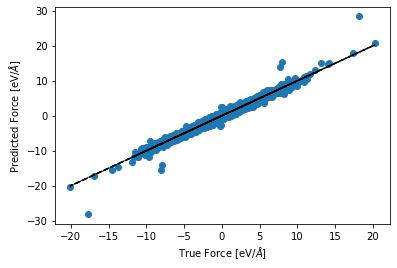

In [7]:
# train the model
representation = AceRepresentation(N, maxdeg, rcut, species, energy_name=energy_name, force_name=force_name, add_sqrt=True)
model_ens = LPEnsemble(representation, n_clusters=12, clustering_type='kmeans', baseline_percentile=0)
model_ens.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise, noise_optimization=False)
# evaluate its performances
%time predictions = model_ens.predict_from_features(val_features, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

CPU times: user 51.6 ms, sys: 132 ms, total: 184 ms
Wall time: 23.8 ms
MAE=0.012 RMSE=0.016 SUP=0.051 R2=0.995
MAE=0.148 RMSE=0.216 SUP=1.957 R2=0.980


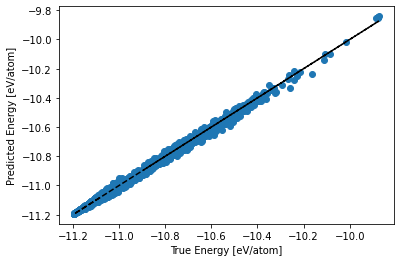

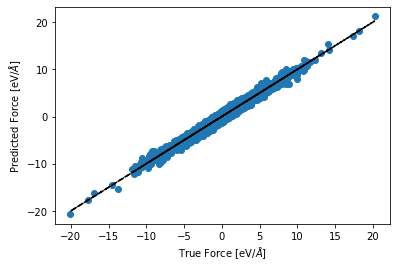

In [8]:
model_lin.update_from_features(val_features, e_val, f_val)

%time predictions = model_lin.predict_from_features(val_features, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

### Expanded Nonlinear Model

Choosing random projection[############################################################] 3/3
MAE=0.013 RMSE=0.020 SUP=0.214 R2=0.992
MAE=0.147 RMSE=0.214 SUP=2.863 R2=0.980


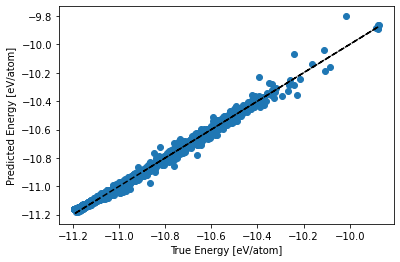

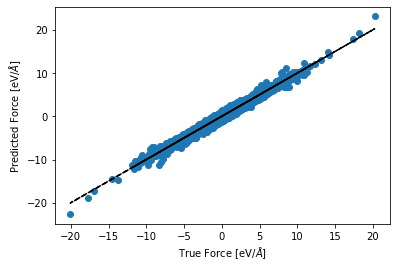

In [29]:
representation = AceRepresentation(N, maxdeg, rcut, species, energy_name=energy_name, force_name=force_name, add_sqrt=True)
model_exp = ExpandedPotential(representation, D=50)
model_exp.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise, noise_optimization=False, iterations=3, kfold=2)
predictions = model_exp.predict_from_features(val_features, forces=True)

ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

### Ensemble Local Model

In [ ]:
# train the model
representation = AceRepresentation(N, maxdeg, rcut, species, energy_name=energy_name, force_name=force_name)
model_ens_loc = LPLocalEnsemble(representation, n_clusters=2, clustering_type='adp', baseline_percentile=0)
model_ens_loc.fit(tr_traj, e_noise, f_noise, global_features=tr_features, noise_optimization=False)
# evaluate its performances
ep, fp = [], []
for i in val_traj:
    predictions = model_ens_loc.predict(i, forces=True)
    ep.extend(predictions['energy'])
    fp.extend(predictions['forces'])
ep = np.array(ep)
fp = np.array(fp)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

### Ensemble Model with Baseline Model (LJ)

In [15]:
representation = AceRepresentation(5, 8, rcut, species, energy_name=energy_name, force_name=force_name)
baseline = LennardJones(epsilon=1.82, sigma=2.2, rc=7, smooth=False)
model_ens_wb = LPEnsemble(representation, baseline_calculator=baseline, n_clusters=1,
                        clustering_type='kmeans', baseline_percentile=0.001)

In [16]:
model_ens_wb.fit(tr_traj, features=tr_features, e_noise=e_noise, f_noise=f_noise)

Computing Baseline Predictions


MAE=0.054 RMSE=0.173 SUP=0.053 R2=0.674
MAE=0.258 RMSE=1.051 SUP=23.477 R2=0.558


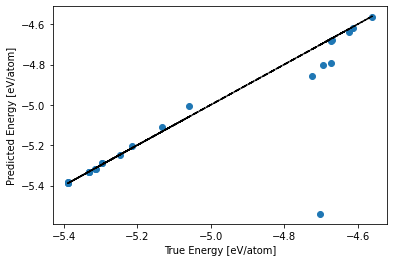

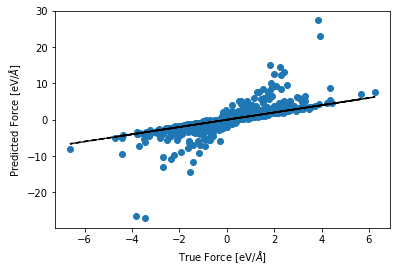

In [17]:
ep, fp = [], []
for i in val_traj:
    predictions = model_ens_wb.predict(i, forces=True)
    ep.extend(predictions['energy'])
    fp.extend(predictions['forces'])
ep = np.array(ep)
fp = np.array(fp)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

# EV Curves

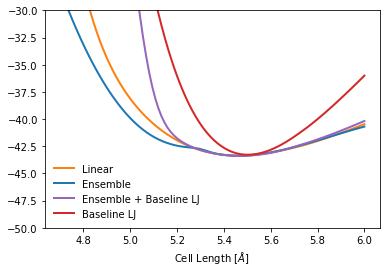

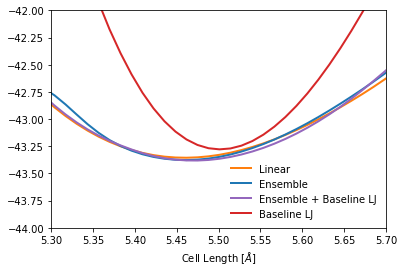

In [9]:
calc_lin = ASEMLCalculator(model_lin)
calc_ens = ASEMLCalculator(model_ens)
calc_ens_wb = ASEMLCalculator(model_ens_wb)
num = 100
en_lin = np.zeros(num)
en_ens = np.zeros(num)
en_ens_wb = np.zeros(num)
en_baseline = np.zeros(num)

distances = np.linspace(4.7, 6, num)
for i in range(num):
    atoms = bulk('Si', 'diamond', a=distances[i], cubic=True)
    atoms.set_calculator(calc_lin)
    en_lin[i] = atoms.get_potential_energy()
    
    atoms.set_calculator(calc_ens)
    en_ens[i] = atoms.get_potential_energy()

    atoms.set_calculator(calc_ens_wb)
    en_ens_wb[i] = atoms.get_potential_energy()
    
    atoms.set_calculator(baseline)
    en_baseline[i] = atoms.get_potential_energy()
    
plt.plot(distances, en_lin, label = 'Linear', lw=2, color = 'tab:orange')
plt.plot(distances, en_ens, label = 'Ensemble', lw=2,  color= 'tab:blue')
plt.plot(distances, en_ens_wb, label = 'Ensemble + Baseline LJ', lw=2, color = 'tab:purple')
plt.plot(distances, en_baseline, label = 'Baseline LJ', lw=2, color = 'tab:red')
plt.legend(frameon=False)
plt.xlabel('Cell Length [$\AA$]')
plt.ylim(-50, -30)
plt.show()

plt.plot(distances, en_lin, label = 'Linear', lw=2, color = 'tab:orange')
plt.plot(distances, en_ens, label = 'Ensemble', lw=2,  color= 'tab:blue')
plt.plot(distances, en_ens_wb, label = 'Ensemble + Baseline LJ', lw=2, color = 'tab:purple')
plt.plot(distances, en_baseline, label = 'Baseline LJ', lw=2, color = 'tab:red')
plt.legend(frameon=False)
plt.xlabel('Cell Length [$\AA$]')
plt.ylim(-44, -42)
plt.xlim(5.3, 5.7)
plt.show()

# MD Runs

In [14]:
atoms = bulk('Si', 'diamond', a=5.5, cubic=True)
atoms.set_calculator(calc_ens)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temp=5000*units.kB)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 2 * units.fs)  # 5 fs time step.

def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

# Now run the dynamics
printenergy(atoms)
for i in range(10):
    dyn.run(100)
    printenergy(atoms)

Energy per atom: Epot = -5.419eV  Ekin = 0.496eV (T=3838K)  Etot = -4.923eV
Energy per atom: Epot = -5.244eV  Ekin = 0.323eV (T=2496K)  Etot = -4.922eV
Energy per atom: Epot = -5.223eV  Ekin = 0.301eV (T=2325K)  Etot = -4.922eV
Energy per atom: Epot = -5.195eV  Ekin = 0.274eV (T=2116K)  Etot = -4.922eV
Energy per atom: Epot = -5.250eV  Ekin = 0.328eV (T=2537K)  Etot = -4.922eV
Energy per atom: Epot = -5.256eV  Ekin = 0.334eV (T=2581K)  Etot = -4.922eV
Energy per atom: Epot = -5.233eV  Ekin = 0.311eV (T=2407K)  Etot = -4.922eV
Energy per atom: Epot = -5.234eV  Ekin = 0.312eV (T=2415K)  Etot = -4.922eV
Energy per atom: Epot = -5.214eV  Ekin = 0.292eV (T=2257K)  Etot = -4.922eV
Energy per atom: Epot = -5.212eV  Ekin = 0.290eV (T=2240K)  Etot = -4.922eV
Energy per atom: Epot = -5.255eV  Ekin = 0.333eV (T=2574K)  Etot = -4.922eV


In [12]:
calc_lin = ASEMLCalculator(model_lin)
atoms = bulk('Si', 'diamond', a=5.5, cubic=True)
atoms.set_calculator(calc_lin)
dyn = VelocityVerlet(atoms, 3 * units.fs)  # 5 fs time step.

%time dyn.run(100)

CPU times: user 12.4 s, sys: 26.9 s, total: 39.4 s
Wall time: 5.06 s


True

In [13]:
calc_ens = ASEMLCalculator(model_ens)
atoms = bulk('Si', 'diamond', a=5.5, cubic=True)
atoms.set_calculator(calc_ens)
dyn = VelocityVerlet(atoms, 3 * units.fs)  # 5 fs time step.

%time dyn.run(100)

CPU times: user 19 s, sys: 43 s, total: 1min 2s
Wall time: 7.87 s


True